In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score, f1_score,confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff

import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/datasets/face_extraction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
# models
vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
eff_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

In [39]:
def extract_features_from_image(image_path): 
    # Verifica se o arquivo é uma imagem válida
    if not os.path.isfile(image_path):
        print(f"[ERRO] O arquivo {image_path} não é válido ou não é uma imagem.")
        return None

    # Carrega a imagem
    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERRO] Não foi possível carregar a imagem {image_path}.")
        return None

    # Redimensiona a imagem
    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Processamento para VGG, ResNet e EfficientNet
    img_batch_vgg = preprocess_vgg(np.expand_dims(img_rgb.astype('float32'), axis=0))
    img_batch_resnet = preprocess_resnet(np.expand_dims(img_rgb.astype('float32'), axis=0))
    img_batch_eff = preprocess_eff(np.expand_dims(img_rgb.astype('float32'), axis=0))

    vgg_feat = vgg_model.predict(img_batch_vgg, verbose=0).flatten()
    res_feat = resnet_model.predict(img_batch_resnet, verbose=0).flatten()
    eff_feat = eff_model.predict(img_batch_eff, verbose=0).flatten()

    combined = np.concatenate([vgg_feat, res_feat, eff_feat])

    return combined  # Retorne a combinação das features

In [40]:
def generate_model(real_path, fake_path, fake_name):
    X_train, y_train = [], []
    X_test, y_test = [], []

    for label, path in [("REAL", real_path), ("FAKE", fake_path)]:
        image_files = os.listdir(path)
        test_files = image_files[:50]
        train_files = image_files[50:]

        for image_name in tqdm(test_files, desc=f"{label} (TESTE)"):
            image_path = os.path.join(path, image_name)
            feat = extract_features_from_image(image_path)
            if feat is not None:
                X_test.append(feat)
                y_test.append(0 if label == "REAL" else 1)

        for image_name in tqdm(train_files, desc=f"{label} (TREINO)"):
            image_path = os.path.join(path, image_name)
            feat = extract_features_from_image(image_path)
            if feat is not None:
                X_train.append(feat)
                y_train.append(0 if label == "REAL" else 1)

    if len(X_train) == 0 or len(X_test) == 0:
        print("Erro: Não foram extraídas características suficientes para o treino ou teste.")
        return

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    svm = SVC(kernel='linear', probability=True)
    svm.fit(X_train_pca, y_train)

    y_pred = svm.predict(X_test_pca)

    print(f"\n=== Avaliação para modelo com FAKE = {fake_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    try:
        y_scores = svm.decision_function(X_test_pca)
        auc = roc_auc_score(y_test, y_scores)
        print("AUC:", auc)
    except:
        print("AUC não disponível.")

    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
    disp.plot()
    plt.title(f"Matriz de Confusão - {fake_name}")
    plt.show()

    # Salvar modelos
    os.makedirs("modelos", exist_ok=True)
    joblib.dump(svm, f"modelos/svm_{fake_name}.joblib")
    joblib.dump(pca, f"modelos/pca_{fake_name}.joblib")

In [41]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
    plt.figure(figsize=(5, 5))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [42]:
def train_all_models():
    real_path = "datasets/face_extraction/REAL/"
    fake_paths = {
        "Deepfake": "datasets/face_extraction/Deepfake/",
        "DeepfakeDetection": "datasets/face_extraction/DeepfakeDetection/",
        "Face2Face": "datasets/face_extraction/Face2Face/",
        "FaceShifter": "datasets/face_extraction/FaceShifter/",
        "FaceSwap": "datasets/face_extraction/FaceSwap/",
        "NeuralTextures": "datasets/face_extraction/NeuralTextures/"
    }

    for fake_name, fake_path in fake_paths.items():
        generate_model(real_path, fake_path, fake_name)

FAKE (TREINO): 100%|██████████| 200/200 [00:25<00:00,  7.95it/s]



=== Avaliação para modelo com FAKE = Deepfake ===
Accuracy: 0.6
F1-score (macro): 0.5974235104669887
AUC: 0.6484
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.68      0.63        50
           1       0.62      0.52      0.57        50

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



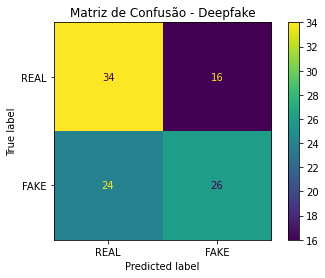

FAKE (TREINO): 100%|██████████| 200/200 [00:25<00:00,  7.77it/s]



=== Avaliação para modelo com FAKE = DeepfakeDetection ===
Accuracy: 0.97
F1-score (macro): 0.9699729756781104
AUC: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        50
           1       0.94      1.00      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



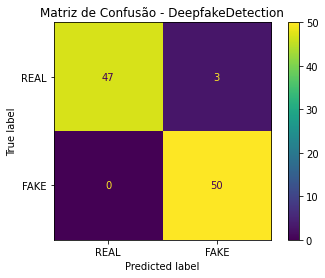

FAKE (TREINO): 100%|██████████| 200/200 [00:25<00:00,  7.96it/s]



=== Avaliação para modelo com FAKE = Face2Face ===
Accuracy: 0.55
F1-score (macro): 0.5477841422972565
AUC: 0.5132
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.48      0.52        50
           1       0.54      0.62      0.58        50

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.55      0.55      0.55       100



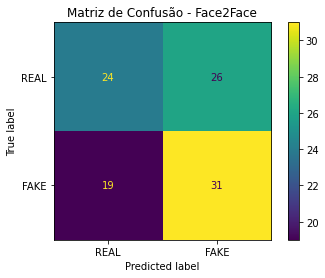

FAKE (TREINO): 100%|██████████| 200/200 [00:25<00:00,  7.82it/s]



=== Avaliação para modelo com FAKE = FaceShifter ===
Accuracy: 0.47
F1-score (macro): 0.4542271650705386
AUC: 0.512
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.30      0.36        50
           1       0.48      0.64      0.55        50

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.45       100
weighted avg       0.47      0.47      0.45       100



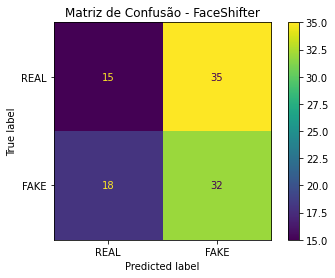

FAKE (TREINO): 100%|██████████| 200/200 [00:25<00:00,  7.71it/s]



=== Avaliação para modelo com FAKE = FaceSwap ===
Accuracy: 0.66
F1-score (macro): 0.6598639455782312
AUC: 0.7036
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67        50
           1       0.67      0.64      0.65        50

    accuracy                           0.66       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.66      0.66      0.66       100



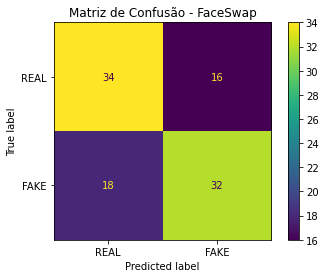

FAKE (TREINO): 100%|██████████| 200/200 [00:25<00:00,  7.97it/s]



=== Avaliação para modelo com FAKE = NeuralTextures ===
Accuracy: 0.48
F1-score (macro): 0.4663382594417077
AUC: 0.5312
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.32      0.38        50
           1       0.48      0.64      0.55        50

    accuracy                           0.48       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.48      0.48      0.47       100



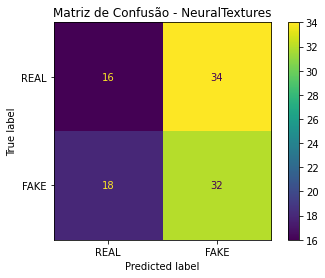

In [45]:
# Execução
train_all_models()